<img src="../assets/notebook.png" />
<hr style="color:#5A7D9F;">
<p align="center">
    <b style="font-size:2vw; color:#5A7D9F; font-weight:bold;">
    <center>Generative Models For Spatial-Based Bottom <br><br> Hypoxia Forecasting In The Black Sea</center>
    </b>
</p>
<hr style="color:#5A7D9F;">

Do not forget to activate the **environnement esa_diffusion**

In [1]:
# ---------- Librairies ----------
import os
import sys
import dawgz
import wandb
import xarray
import random
import numpy             as np
import pandas            as pd
import seaborn           as sns
import matplotlib.pyplot as plt

# Pytorch
import torch
import torch.nn as nn
import torch.optim as optim

# ---------- Jupyter ----------
%matplotlib inline
plt.rcParams.update({'font.size': 13})

# Making sure modules are reloaded when modified
%reload_ext autoreload
%autoreload 2

<hr style="color:#5A7D9F;">
<p align="center">
    <b style="font-size:2vw; color:#5A7D9F; font-weight:bold;">
    <center>Playground</center>
    </b>
</p>
<hr style="color:#5A7D9F;">

In [ ]:
import os
import ast
import wandb
import numpy as np
import xarray as xr

# --------------------------------
#        Script Parameters
# --------------------------------
#
# Define wheter or not use WandB
USE_WANDB = False

# High Resolution Simulation (Without Chlorophyll assimilation)
DATA_PATH = "~/../../../../projects/acad/bsmfc/nemo4.2.0/BSFS_BIO/output_HR001/"

# Used to save the final dataset
SAVE_PATH = "~/../../../../scratch/acad/bsmfc/victor/data/deep_learning_3D/"

# Name of the folder containing the data
FOLDER_NAME = "training"

# Time Period
YEAR_START = 1980
YEAR_END   = 1980

# Determine wheter or not use a custom region
USE_CUSTOM_REGION = True

# Region to keep
X_START, X_END = 108, 236
Y_START, Y_END = 108, 236
Z_END          = 32

# Choose wheter or not to save the mask
SAVE_MASK = False

# Variables to keep
"""
DATA_VARIABLES = [
    "votemper",
    "vosaline",
    "CHL",
    "DOX",
    "ssh",
    ]
"""

DATA_VARIABLES = [
    "votemper",
    "ssh",
    ]

# --------------------------------
#            Security
# --------------------------------
#
# Cannot use 1981
#
assert YEAR_START >= 1980 and YEAR_END <= 2023,     "Time period must be between 1980 and 2023 (YEAR_START)"
assert YEAR_END >= YEAR_START and YEAR_END <= 2023, "Time period must be between 1980 and 2023 (YEAR_END)"
assert FOLDER_NAME in ["training", "validation", "testing"], "Folder name must be either 'training', 'validation' or 'testing'"

# Retrieving path to datasets
with open('poseidon/paths/grid_T.txt', 'r') as file:
    data_physics = ast.literal_eval(file.read())
with open('poseidon/paths/ptrc_T.txt', 'r') as file:
    data_biogeochemistry = ast.literal_eval(file.read())

# --------------------------------
#      Preprocessing - Mask
# --------------------------------
# Loading the dataset storing the mask
dataset_mask_complete = xr.open_dataset("~/../../../../projects/acad/bsmfc/nemo4.2.0/BSFS/mesh_mask.nc_new59_CMCC_noAzov", engine="netcdf4")

# Extracting the mask
mask = dataset_mask_complete["mbathy"][0].values

# Used to trim the data to become multiple of 2
x_trim, y_trim = 576, 256

# Trimming
mask = mask[:y_trim, :x_trim]

# Stores a 3D version of the mask
mask_matrix = np.ones((59, y_trim, x_trim))

# Filling the matrix (1 = Black Sea, 0 = Land)
for l in range(59):
    mask_matrix[l, mask <= l] = 0

# Creation of the final dataset containing the mask
dataset_mask = xr.Dataset(
    {
        "mask": (["nav_lev", "y", "x"], mask_matrix)
    },
    coords = {
        "x": np.arange(0, x_trim),
        "y": np.arange(0, y_trim),
        "nav_lev": np.arange(0, 59)
    }
)

# --------------------------------
#    Preprocessing - Statistics
# --------------------------------
# Used to compute the mean (3D (everywhere) and 2D (surface)) of the data
means = [0 for i in range(len(DATA_VARIABLES))]

# Used to compute the variance (3D (everywhere) and 2D (surface)) of the data
vars = [0 for i in range(len(DATA_VARIABLES))]

# Used to count the number of data points (temporaly)
n_samples = 0

# Initialization of Weights and Biases
wandb.init(project = 'Poseidon - Preprocessing', mode = 'disabled' if not USE_WANDB else 'online')

# ----- MEAN
for y in range(YEAR_START, YEAR_END+1):
    for m in range(1, 13):

        # Sending information to Weights and Biases (1)
        wandb.log({"Mean/year": y, "Mean/month": m})

        # Creating the key to access the data
        key = f"{y:04d}-{m:02d}"

        # Creating the paths
        paths = [DATA_PATH + p for p in data_physics[key] + data_biogeochemistry[key]]

        # Loading view of the data
        data = xr.open_mfdataset(paths, combine = 'by_coords')

        # Extracting the variables
        data = data[DATA_VARIABLES]

        # Updating the number of samples (used for temporal average)
        n_samples += data.sizes['time_counter']

        # Updating the means (average spatially)
        for i, variable in enumerate(data.data_vars):

            # Extracting the data
            var_data = data[variable].values if variable != "DOX" else np.clip(data[variable].values, 0, np.inf)

            # Total number of points
            n_points = np.sum(mask_matrix) if var_data.ndim == 4 else np.sum(mask_matrix[0])

            # Define surface variables on 3D volumes
            if var_data.ndim == 3:

                # Extracting dimensions
                t, y, x = var_data.shape

                # Creating the domain
                domain = np.zeros((t, 59, y, x))

                # Filling the surface
                domain[:, 0, ...] = var_data

                # Updating the variable
                var_data = domain

            # Trimming the data
            var_data = var_data[..., :y_trim, :x_trim]

            # Removing NaNs
            var_data[:, mask_matrix == 0] = 0

            # Updating mean
            means[i] += np.nansum(var_data)/n_points

        break
    break

# Temporal Average
means = [mean / n_samples for mean in means]

# ------ VARIANCE
for y in range(YEAR_START, YEAR_END+1):
    for m in range(1, 13):

        # Sending information to Weights and Biases (2)
        wandb.log({"Variance/year": y, "Variance/month": m})

        # Creating the key to access the data
        key = f"{y:04d}-{m:02d}"

        # Creating the paths
        paths = [DATA_PATH + p for p in data_physics[key] + data_biogeochemistry[key]]

        # Loading view of the data
        data = xr.open_mfdataset(paths, combine = 'by_coords')

        # Extracting the variables
        data = data[DATA_VARIABLES]

        # Updating the vars (sum((x - mu) ** 2)/n)
        for i, variable in enumerate(data.data_vars):

            # Extracting the data
            var_data = data[variable].values if variable != "DOX" else np.clip(data[variable].values, 0, np.inf)

            # Total number of points
            n_points = np.sum(mask_matrix) if var_data.ndim == 4 else np.sum(mask_matrix[0])

            # Define surface variables on 3D volumes
            if var_data.ndim == 3:

                # Extracting dimensions
                t, y, x = var_data.shape

                # Creating the domain
                domain = np.zeros((t, 59, y, x))

                # Filling the surface
                domain[:, 0, ...] = var_data

                # Updating the variable
                var_data = domain

            # Trimming the data
            var_data = var_data[..., :y_trim, :x_trim]

            # Computing the variance pixel-wise
            var_data = np.power(var_data - means[i], 2)

            # Removing NaNs and masking biased values
            var_data[:, mask_matrix == 0] = 0

            # Computing the variance
            vars[i] += np.sum(var_data)/n_points

        break
    break

# Computing the variance
vars = [var / n_samples for var in vars]

# Computing the standard deviation
stds = [np.sqrt(var) for var in vars]

# ---------------------------------
#  Preprocessing - Standardization
# ---------------------------------
for y in range(YEAR_START, YEAR_END+1):
    for m in range(1, 13):

        # Sending information to Weights and Biases (3)
        wandb.log({"Standardization/year": y, "Standardization/month": m})

        # Creating the key to access the data
        key = f"{y:04d}-{m:02d}"

        # Creating the paths
        paths = [DATA_PATH + p for p in data_physics[key] + data_biogeochemistry[key]]

        # Loading view of the data
        data = xr.open_mfdataset(paths, combine = 'by_coords')

        # Extracting the variables
        data = data[DATA_VARIABLES]

        # Stores the preprocessed data and their name
        preprocessed_data = []

        # Standardization
        for i, variable in enumerate(data.data_vars):

            # Extracting the data
            var_data = data[variable].values if variable != "DOX" else np.clip(data[variable].values, 0, np.inf)

            # Define surface variables on 3D volumes
            if var_data.ndim == 3:

                # Extracting dimensions
                t, y, x = var_data.shape

                # Creating the domain
                domain = np.zeros((t, 59, y, x))

                # Filling the surface
                domain[:, 0, ...] = var_data

                # Updating the variable
                var_data = domain

            # ---------
            # IMPORTANT
            # ---------
            # Trimming the data
            var_data = var_data[..., :y_trim, :x_trim]

            # Removing NaNs to avoid errors when standardizing
            var_data[:, mask_matrix == 0] = 0

            # Standardizing the data
            var_data = (var_data - means[i]) / stds[i]

            # Removing land values
            var_data[:, mask_matrix == 0] = 0

            # Extracting the region of interest
            if USE_CUSTOM_REGION:
                var_data = var_data[:, :Z_END, Y_START:Y_END, X_START:X_END]

            # Flipping the data to display Black Sea correctly
            var_data = np.flip(var_data, axis = 2)

            # Adding the data to the list
            preprocessed_data.append([variable, var_data])

        # ---------------------------------
        #     Preprocessing - Saving (1)
        # ---------------------------------
        # Creating the final dataset (preprocessed data and dates)
        dataset_final = xr.Dataset(
            {
                preprocessed_data[i][0]: (["time_counter", "nav_lev", "y", "x"], preprocessed_data[i][1]) for i in range(len(preprocessed_data))
            },
            coords = {
                "time_counter": data["time_counter"],
                "nav_lev": np.arange(0, preprocessed_data[0][1].shape[1]),
                "y": np.arange(0, preprocessed_data[0][1].shape[2]),
                "x": np.arange(0, preprocessed_data[0][1].shape[3])
            }
        )

        # Saving the final dataset
        dataset_final.to_zarr(f"deep_learning_black_sea_data_3D_{key}.zarr")


        break
    break






# Saving the mask
dataset_mask.to_zarr(SAVE_PATH + "mask/mask.zarr") if SAVE_MASK else None
        # Load the data into memory
        # data.compute()

        # Saving the data as zarr files
        # data.to_zarr(SAVE_PATH + FOLDER_NAME + f"/deep_learning_black_sea_dataset_3D_{key}.zarr")

In [3]:
import ast
import wandb
import numpy as np
import xarray as xr

# --------------------------------
#        Script Parameters
# --------------------------------
#
# Wheter or not doing
USE_WANDB         = False
USE_CUSTOM_REGION = True
SAVE_MASK         = False

# Name of the final destination folder
FOLDER_NAME = "training"

# High Resolution Data to load
DATA_PATH = "~/../../../../projects/acad/bsmfc/nemo4.2.0/BSFS_BIO/output_HR001/"

# Main folder containing the different datasets
SAVE_PATH = "~/../../../../scratch/acad/bsmfc/victor/data/deep_learning_3D/"

# Path to the mask
MASK_PATH = "~/../../../../projects/acad/bsmfc/nemo4.2.0/BSFS/mesh_mask.nc_new59_CMCC_noAzov"

# Time Period
YEAR_START = 1980
YEAR_END   = 1980

# Region
X_START, X_END = 108, 236
Y_START, Y_END = 108, 236
Z_END          = 32

# Variables (Can be either surface of volumetric)
DATA_VARIABLES = [
    "votemper",
    #"vosaline",
    #"CHL",
    #"DOX",
    "ssh",
    ]

# Variables to clip (to avoid negative values if not physical)
DATA_CLIPPING = [
    "DOX",
    ]

# --------------------------------
#            Security
# --------------------------------
#
# A bunch of asserts
#
# 1. Time Period
#
# 2. Region indices
#
# 3. Existing folders
#
# --------------------------------
#    Preprocessing (1) - MASK
# --------------------------------
# Extracting mapping between dates and files
with open('poseidon/paths/grid_T.txt', 'r') as file:
    data_physics = ast.literal_eval(file.read())

with open('poseidon/paths/ptrc_T.txt', 'r') as file:
    data_biogeochemistry = ast.literal_eval(file.read())

# ----
# MASK
# ----
# Loading the dataset storing the mask
dataset_mask_complete = xr.open_dataset(MASK_PATH, engine= "netcdf4")

# Extracting the mask (indices define the bottom)
mask = dataset_mask_complete["mbathy"][0].values

# Extracting the region of interest
mask = mask[Y_START:Y_END, X_START:X_END] if USE_CUSTOM_REGION else mask

# Conversion to a 3D mask with specific depth
mask_matrix = np.ones((Z_END, mask.shape[0], mask.shape[1])) if USE_CUSTOM_REGION else np.ones((59, mask.shape[0], mask.shape[1]))

# Filling the 3D mask (1 = Black Sea, 0 = Land)
for l in range(mask_matrix.shape[0]):
    mask_matrix[l, mask <= l] = 0

# --------------------------------
#    Preprocessing (2) - Data
# --------------------------------
# Initialization of Weights and Biases
wandb.init(project = 'Poseidon - Preprocessing', mode = 'disabled' if not USE_WANDB else 'online')

# Used to store statistics
means = [0 for i in range(len(DATA_VARIABLES))]
vars  = [0 for i in range(len(DATA_VARIABLES))]

# Counts the number of samples (used for temporal average)
n_samples = 0

# Computing statistics, standardizing the data and saving it
for stat_index, stat_name in enumerate(["Mean", "Variance", "Standardization"]):

    # Computing for each month of the year
    for y in range(YEAR_START, YEAR_END + 1):
        for m in range(1, 13):

            # Sending information to Weights and Biases
            wandb.log({f"{stat_name}/year": y, f"{stat_name}/month": m})

            # Creating the key to access the data
            key = f"{y:04d}-{m:02d}"

            # Creating the paths
            paths = [DATA_PATH + p for p in data_physics[key] + data_biogeochemistry[key]]

            # Loading view of the data
            data = xr.open_mfdataset(paths, combine = 'by_coords')

            # Extracting the variables
            data = data[DATA_VARIABLES]

            # Updating the number of samples (used for temporal average)
            n_samples += data.sizes['time_counter'] if stat_index == 0 else 0

            # Used to store data and its name (Only for standardization)
            preprocessed_data = []

            # ------- Looping over the variables --------
            for i, variable in enumerate(data.data_vars):

                # Extracting the data and clipping it
                var_data = data[variable].values if variable not in DATA_CLIPPING else np.clip(data[variable].values, 0, np.inf)

                # Total number of cells
                n_points = np.sum(mask_matrix) if var_data.ndim == 4 else np.sum(mask_matrix[0])

                # Conversion of surface variables to volume
                if var_data.ndim == 3:
                    t, y, x = var_data.shape
                    domain = np.zeros((t, 59, y, x))
                    domain[:, 0, ...] = var_data
                    var_data = domain

                # Extracting the region of interest
                var_data = var_data[:, :Z_END, Y_START:Y_END, X_START:X_END] if USE_CUSTOM_REGION else var_data

                # Setting eveything in the land to null value
                var_data[:, mask_matrix == 0] = 0

                # --------- Statistics & Others (1) ---------
                if stat_index == 0:

                    # Computing the spatial mean
                    means[i] += np.nansum(var_data)/n_points

                elif stat_index == 1:

                    # Computing the variance pixel-wise
                    var_data = np.power(var_data - means[i], 2)

                    # Removing biased values (land is now not set to 0)
                    var_data[:, mask_matrix == 0] = 0

                    # Computing the variance
                    vars[i] += np.nansum(var_data)/n_points

                elif stat_index == 2:

                    # Standardizing the data
                    var_data = (var_data - means[i]) / stds[i]

                    # Removing biased values (land is now not set to 0)
                    var_data[:, mask_matrix == 0] = 0

                    # Flipping the data to display Black Sea correctly
                    var_data = np.flip(var_data, axis = 2)

                    # Adding the data to the list
                    preprocessed_data.append([variable, var_data])

                else:
                    print("ERROR (generating.py) - Unknown Step")

            break # MONTH

        break # YEAR

    # --------- Statistics & Others (2) ---------
    #
    if stat_index == 0:

        # Computing the spatial-temporal mean
        means = [mean / n_samples for mean in means]

    if stat_index == 1:

        # Computing the spatial-temporal variance
        vars = [var / n_samples for var in vars]

        # Computing the spatial-temporal standard deviation
        stds = [np.sqrt(var) for var in vars]

    if stat_index == 2:

        # Creating the final dataset containing the preprocessed data and associated dates
        dataset_final = xr.Dataset(
            {
                preprocessed_data[i][0]: (["time_counter", "nav_lev", "y", "x"], preprocessed_data[i][1]) for i in range(len(preprocessed_data))
            },
            coords = {
                "time_counter": data["time_counter"],
                "nav_lev": np.arange(0, preprocessed_data[0][1].shape[1]),
                "y": np.arange(0, preprocessed_data[0][1].shape[2]),
                "x": np.arange(0, preprocessed_data[0][1].shape[3])
            }
        )

        # Saving the final dataset
        dataset_final.to_zarr(f"deep_learning_black_sea_data_3D_{key}.zarr")

# --------------------------------
#    Preprocessing (3) - Others
# --------------------------------
#
# Flipping the data to display Black Sea correctly
mask_matrix = np.flip(mask_matrix, axis = 1)

# Creating a meshgrid
x_mesh, y_mesh, z_mesh = np.meshgrid(np.arange(0, mask_matrix.shape[2]), np.arange(0, mask_matrix.shape[1]), np.arange(0, mask_matrix.shape[0]))

# Depth is first
x_mesh, y_mesh, z_mesh = np.swapaxes(x_mesh, 0, 2), np.swapaxes(y_mesh, 0, 2), np.swapaxes(z_mesh, 0, 2)

# Creating the final dataset containing the mask and mesh
dataset_utils= xr.Dataset(
    {
        "mask"  : (["nav_lev", "y", "x"], mask_matrix),
        "x_mesh": (["nav_lev", "y", "x"], x_mesh),
        "y_mesh": (["nav_lev", "y", "x"], y_mesh),
        "z_mesh": (["nav_lev", "y", "x"], z_mesh)
    },
    coords = {
        "x"      : np.arange(0, mask_matrix.shape[2]),
        "y"      : np.arange(0, mask_matrix.shape[1]),
        "nav_lev": np.arange(0, mask_matrix.shape[0])
    }
)

# Saving the mask
dataset_utils.to_zarr(f"deep_learning_black_sea_data_3D_utils.zarr")

In [99]:
import numpy as np
import xarray as xr

data_test  = xr.open_zarr("deep_learning_black_sea_data_3D_1980-01.zarr")
utils_test = xr.open_zarr("deep_learning_black_sea_data_3D_utils.zarr")

In [100]:
data_test

<xarray.Dataset> Size: 195MB
Dimensions:        (nav_lev: 32, time_counter: 31, y: 128, x: 128)
Coordinates:
  * nav_lev        (nav_lev) int64 256B 0 1 2 3 4 5 6 7 ... 25 26 27 28 29 30 31
    time_centered  (time_counter) datetime64[ns] 248B dask.array<chunksize=(1,), meta=np.ndarray>
  * time_counter   (time_counter) datetime64[ns] 248B 1980-01-01T12:00:00 ......
    time_instant   (time_counter) datetime64[ns] 248B dask.array<chunksize=(1,), meta=np.ndarray>
  * x              (x) int64 1kB 0 1 2 3 4 5 6 7 ... 121 122 123 124 125 126 127
  * y              (y) int64 1kB 0 1 2 3 4 5 6 7 ... 121 122 123 124 125 126 127
Data variables:
    ssh            (time_counter, nav_lev, y, x) float64 130MB dask.array<chunksize=(8, 8, 32, 64), meta=np.ndarray>
    votemper       (time_counter, nav_lev, y, x) float32 65MB dask.array<chunksize=(8, 8, 64, 64), meta=np.ndarray>

In [101]:
utils_test

<xarray.Dataset> Size: 17MB
Dimensions:  (nav_lev: 32, y: 128, x: 128)
Coordinates:
  * nav_lev  (nav_lev) int64 256B 0 1 2 3 4 5 6 7 8 ... 24 25 26 27 28 29 30 31
  * x        (x) int64 1kB 0 1 2 3 4 5 6 7 8 ... 120 121 122 123 124 125 126 127
  * y        (y) int64 1kB 0 1 2 3 4 5 6 7 8 ... 120 121 122 123 124 125 126 127
Data variables:
    mask     (nav_lev, y, x) float64 4MB dask.array<chunksize=(16, 64, 64), meta=np.ndarray>
    x_mesh   (nav_lev, y, x) int64 4MB dask.array<chunksize=(16, 64, 64), meta=np.ndarray>
    y_mesh   (nav_lev, y, x) int64 4MB dask.array<chunksize=(16, 64, 64), meta=np.ndarray>
    z_mesh   (nav_lev, y, x) int64 4MB dask.array<chunksize=(16, 64, 64), meta=np.ndarray>

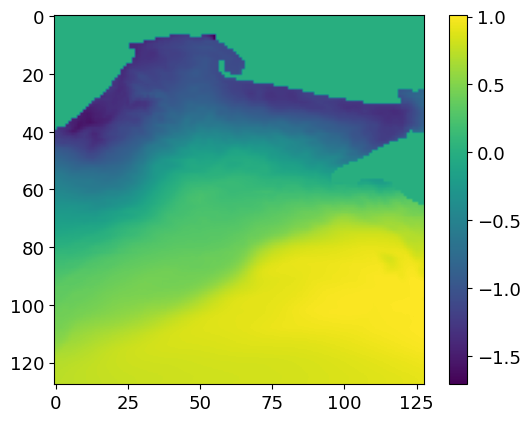

In [102]:
plt.imshow(data_test["votemper"][0, 0, ...])
plt.colorbar()

In [122]:
np.mean(data_test["votemper"][:, utils_test["mask"] == 1])

IndexError: 3-dimensional boolean indexing is not supported. 

In [120]:
np.mean(data_test["ssh"].values[:, 0, utils_test["mask"].values[0] == 1])

-2.3533587246151326e-17

(128, 128)

In [121]:
data_test["ssh"].values.shape

(31, 32, 128, 128)